In [ ]:
!nvidia-smi

Tue Jun 21 09:09:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "yourname" 
os.environ['KAGGLE_KEY'] = "yourkey"
!kaggle datasets download -d joangibert/tcga_coad_msi_mss_jpg

In [ ]:
from zipfile import ZipFile
file_name = "/content/tcga_coad_msi_mss_jpg.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import shutil
import math

In [ ]:
ROOT_DIR = "/content/dataset"

num_of_images = {}

for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

num_of_images

{'MSI': 75039, 'MSS': 117273}

In [ ]:
if not os.path.exists("./test"):
  os.mkdir("./test")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./test/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= 15000 , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./test', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Test Klasörü Mevcut")

In [ ]:
train_path = '/content/train'
test_path = '/content/test'

In [ ]:
train_root = train_path

num_of_images = {}

for i in os.listdir(train_root):
  num_of_images[i] = len(os.listdir(os.path.join(train_root, i)))

num_of_images

{'MSI': 60000, 'MSS': 60000}

In [ ]:
test_root = test_path

num_of_images = {}


for i in os.listdir(test_root):
  num_of_images[i] = len(os.listdir(os.path.join(test_root, i)))
  

num_of_images

{'MSI': 15000, 'MSS': 15000}

In [ ]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
training_data_dir ="/content/train" 
test_data_dir = "/content/test" 

In [ ]:
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =10
BATCH_SIZE =64
learning = 1e-5
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"

In [ ]:
%matplotlib inline

base_model=VGG19(input_shape=(224,224,3),weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=RMSprop(learning_rate=learning,rho=0.9, centered=False), loss='binary_crossentropy',metrics=['accuracy'])


model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    subset ='training',
    class_mode="binary", shuffle=True)
validation_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode="binary", shuffle = True)

Found 96000 images belonging to 2 classes.
Found 24000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc= ModelCheckpoint('en_iyi_model.h5',save_best_only=True,monitor='val_loss',mode='min')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import datetime
import time
start = datetime.datetime.now()
# Training
H = model.fit_generator(
    training_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[mc, CSVLogger(TRAINING_LOGS_FILE,append=False,separator=";")],verbose=1)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

model.save_weights(MODEL_FILE)

Epoch 1/10
1500/1500 [==============================] - 1763s 1s/step - loss: 0.5561 - accuracy: 0.7070 - val_loss: 0.4733 - val_accuracy: 0.7698
Epoch 2/10
1500/1500 [==============================] - 1750s 1s/step - loss: 0.4426 - accuracy: 0.7886 - val_loss: 0.3784 - val_accuracy: 0.8284
Epoch 3/10
1500/1500 [==============================] - 1810s 1s/step - loss: 0.3749 - accuracy: 0.8269 - val_loss: 0.3408 - val_accuracy: 0.8511
Epoch 4/10
1500/1500 [==============================] - 1811s 1s/step - loss: 0.3291 - accuracy: 0.8521 - val_loss: 0.3070 - val_accuracy: 0.8632
Epoch 5/10
1500/1500 [==============================] - 1752s 1s/step - loss: 0.2944 - accuracy: 0.8700 - val_loss: 0.3938 - val_accuracy: 0.8266
Epoch 6/10
1500/1500 [==============================] - 1752s 1s/step - loss: 0.2657 - accuracy: 0.8842 - val_loss: 0.3512 - val_accuracy: 0.8457
Epoch 7/10
1500/1500 [==============================] - 1754s 1s/step - loss: 0.2415 - accuracy: 0.8960 - val_loss: 0.2514 -

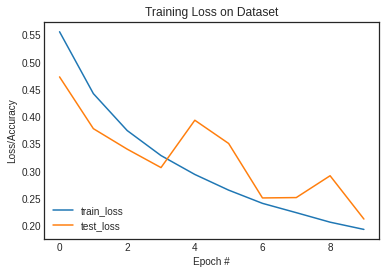

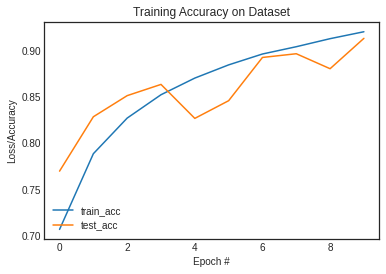

In [ ]:
N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
vggmodel = load_model('/content/en_iyi_model.h5')

In [ ]:
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False)

Found 30000 images belonging to 2 classes.


In [ ]:
loss, accuracy = vggmodel.evaluate(test_generator)
print("Test: accuracy = %f ; loss = %f " %(accuracy,loss))

469/469 [==============================] - 185s 393ms/step - loss: 0.2250 - accuracy: 0.9059
Test: accuracy = 0.905933 ; loss = 0.224981 


Confusion Matrix


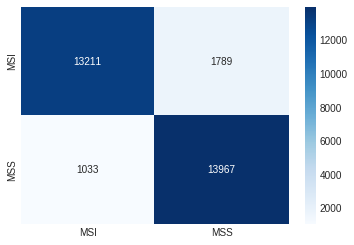

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true_val = test_generator.classes
y_pred = np.round(vggmodel.predict(test_generator),0)
cm=confusion_matrix(y_true_val, y_pred)
print('Confusion Matrix')
target_names = ["MSI","MSS"]
sns.heatmap(cm, annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)


In [ ]:
print('Classification Report')
print(classification_report(y_true_val, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         MSI       0.93      0.88      0.90     15000
         MSS       0.89      0.93      0.91     15000

    accuracy                           0.91     30000
   macro avg       0.91      0.91      0.91     30000
weighted avg       0.91      0.91      0.91     30000



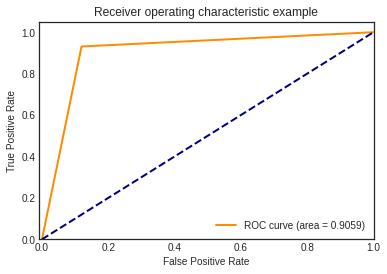

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(test_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()